## Road and Traffic Analytics - Exploration 

### This Notebook is an exploration of data aimed to find new ways to optimize and understand the arterial and motorway network

### Heatmap with Python, SNS to show traffic congestion waves

A function to give an idea about how traffic is flowing through freeway sections.

It is important to note that freeways have certain properties that make the use of this type of heatmap particularly valuable. Congestion builds in waves, so over time it is useful to see how those waves form. Once congestion starts on a freeway and heads past a critical point it leads to much more congestion. Each detector is situated a certain distance along a distance, thus showing how congestion moves through the system. The detector types are either stud detectors, which do break quite often and thus lead to anomalous data, or TIRL detectors, which use a laser / light and break less often but are not as common.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import math
import numpy as np
%matplotlib inline

In [4]:
## import matplotlib.pyplot as plt
def mix_palette():
    palette = sns.color_palette("GnBu", 10)
    palette[9] = sns.color_palette("OrRd", 10)[9]
    return palette


def set_ax(iax):
    iax.collections[0].colorbar.set_ticklabels(['10', '30'])
    for text in iax.texts:
        if float(text.get_text()) < 30:
            text.set_text("")
    iax.figure.tight_layout()
    iax.set_title("Occupancy")

    
def set_bx(ibx):
    ibx.fig.suptitle("Occupancy")

def load_data(path):
    initial = pd.read_csv(path)
    columns = list(initial.columns.values)[1:]
    rows = []
    for values in initial.values:
        rng = values[0]
        for column, value in zip(columns, values[1:]):
            rows.append([rng, column, value])
    return pd.DataFrame(data=rows, columns=['Detector', 'Time', 'Occupancy'])



### Data input and settings for SNS plot
This can be turned into a function to be used more generally. The cluster map can show a difference perspective on areas of high congestion and also broken detectors. This example is using occupancy, which is a measurement showing how often the detector has a car over it, which is useful for freeways versus volume or speed as a measurement.

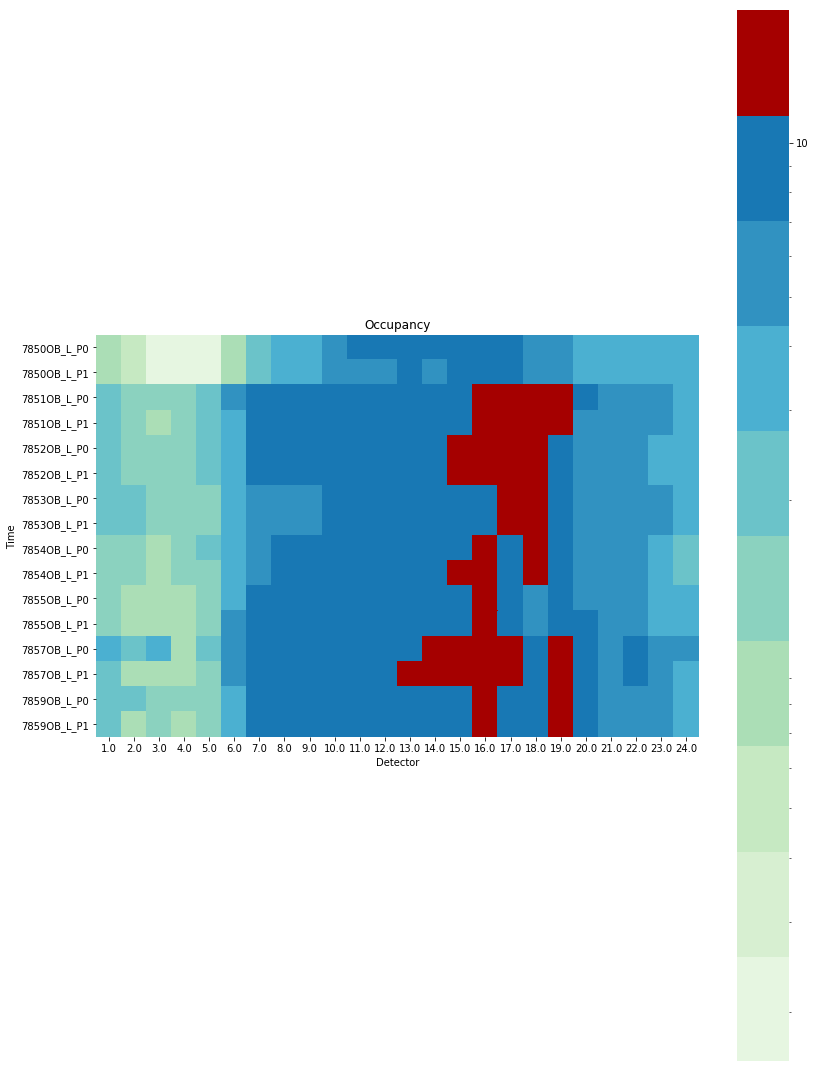

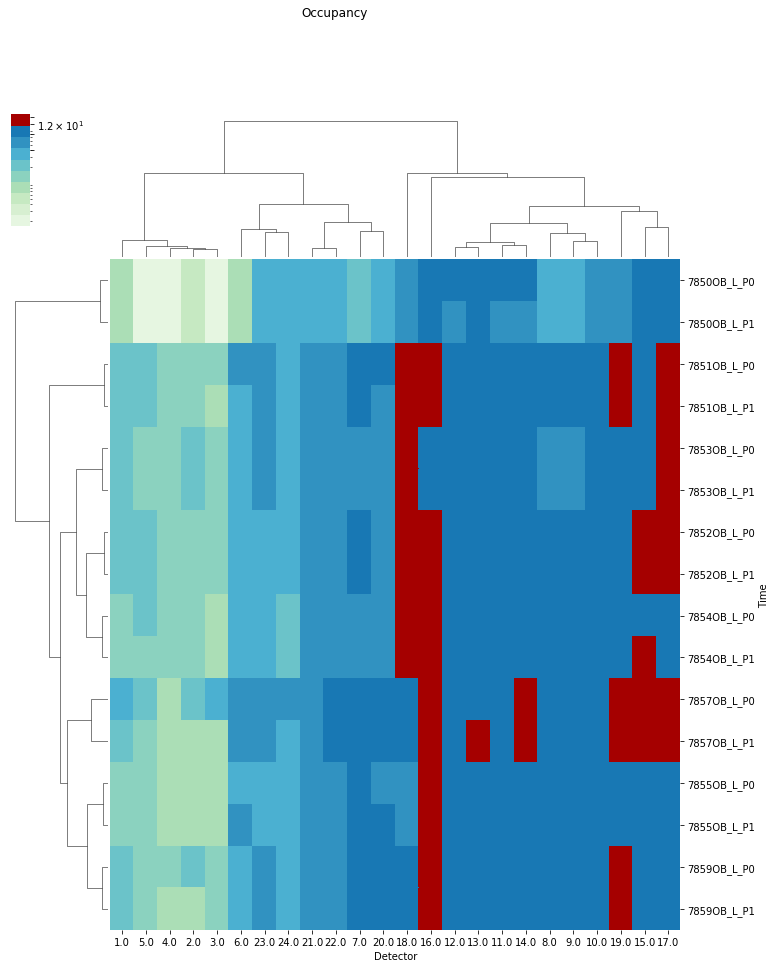

In [5]:
data_set = '1hrwestgate.csv'
data = load_data(data_set)
data = data.pivot("Time", "Detector", "Occupancy")
mi, ma = data.values.min(), data.values.max()


plt.figure(figsize = (12,15))
ax = sns.heatmap(data, cmap=mix_palette(), annot=True, square=True, cbar_kws={'ticks':[10,30]},
                 xticklabels=True, yticklabels=True, norm=LogNorm(vmin=mi, vmax=ma))
set_ax(ax)
plt.savefig('image.png', bbox_inches='tight')
plt.show()

bx = sns.clustermap(data, figsize = [12,15], cmap=mix_palette(), norm=LogNorm(vmin=mi, vmax=ma) )
set_bx(bx)
plt.savefig('cluster.png', bbox_inches='tight')
plt.show()

## This is the function to re-purpose this code for more data and different data types (in process)

In [6]:
def read_data(source,sheetname):
    data = pd.read_excel(source, sheet_name= sheetname)
    data = data[:-1]
    times = data['Row Labels'].str.extract('(\d\d):(\d\d)').astype(int)
    times2 = times.rename(columns={0: 'Hour', 1: 'Minute'})
    data2 = pd.concat([data, times2], axis=1)
    del data2['Row Labels']
    data3= data2.set_index(['Hour', 'Minute'])
    return data3


def heatmap(data_set):
    
    plt.figure(figsize = (12,15))
    ax = sns.heatmap(data_set, cmap=mix_palette(), annot=True, square=True, cbar_kws={'ticks':[10,30]},
                 xticklabels=True, yticklabels=True, norm=LogNorm(vmin=mi, vmax=ma))
    set_ax(ax)
    plt.savefig('image.png', bbox_inches='tight')
    plt.show()


# Managed Motorway Analytics Map exploration

#### Mapping data using GIS and heatmaps would be allow road operators to understand the motorway as a system and adjust the ramp signals accordingly. This example will just use the detector data, but we will be moving into other data types in a further example.

Useful links
https://ipyleaflet.readthedocs.io/en/latest/

In [7]:
import pandas as pd
det_info ="Data.csv"
detector_information = pd.read_csv(det_info)

In [8]:
detector_information.head()

,Y,X,Capacity Source,Short Name,Movement,State,Smoothed Occupancy (%),Smoothed Total Flow (veh/h),System,Unnamed: 9
0,-37.825233,144.829434,Upper Limit,2541EL_P0,"Combined Entry MVT on Grieve Pde, West Gate Fw...",OK,11.39,665.14,VicRoads Production,NaN
1,-37.825234,144.829502,Upper Limit,2541EL_P1,"Combined Entry MVT on Grieve Pde, West Gate Fw...",OK,9.17,679.85,VicRoads Production,NaN
2,-37.732708,144.881846,Measured,1917EL_P0,Combined Entry MVT on Keilor Rd WB between Kei...,OK,4.03,344.74,VicRoads Production,NaN
3,-37.732701,144.881781,Measured,1917EL_P1,Combined Entry MVT on Keilor Rd WB between Kei...,OK,4.01,344.93,VicRoads Production,NaN
4,-37.732571,144.881337,Measured,1917M0_P0,Combined Entry MVT on Keilor Rd WB between Kei...,OK,3.55,291.83,VicRoads Production,NaN


In [9]:
Coordinates = detector_information.set_index("Short Name")[["Y","X"]]

In [10]:
Coordinates.head()

,Y,X
Short Name,,
2541EL_P0,-37.825233,144.829434
2541EL_P1,-37.825234,144.829502
1917EL_P0,-37.732708,144.881846
1917EL_P1,-37.732701,144.881781
1917M0_P0,-37.732571,144.881337


In [11]:
Coordinates.index[0]

'2541EL_P0'

In [12]:
Coordinates.Y[0]

-37.825233000000004

In [13]:

Coordinates.X[0]

144.82943400000002

In [14]:
def GPS(n):
    Coordinates = detector_information.set_index("Short Name")[["Y","X"]]
    return {"Name" : Coordinates.index[n], "GPS" :(Coordinates.Y[n], Coordinates.X[n])}


In [15]:
from ipyleaflet import Map, Heatmap
from random import uniform
m = Map(center=(-37.814, 144.96332), zoom=11)

heatmap = Heatmap(
    locations=[
        (-37.735018, 144.894947, 20), # lat, lng, intensity
        (-38, 145, 30),               # lat, lng, intensity
    ],
    radius=20
)

m.add_layer(heatmap);

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [16]:
import pandas as pd
from ipyleaflet import Marker, Map, MarkerCluster

det_info ="Data.csv"
detector_information = pd.read_csv(det_info)

center = (-37.814 , 144.96332) #This is the lat long of Melbourne

def GPS(n):
    Coordinates = detector_information.set_index("Short Name")[["Y","X"]]
    return {"Name" : Coordinates.index[n], "GPS" :(Coordinates.Y[n], Coordinates.X[n])}

Detectors = {}

Detectors[0] = { "Name" : "14352OB_L1P0",
                "GPS" : (-37.735018, 144.894947)
               }
Detectors[1] = { "Name" : "14352OB_L1P1",
                "GPS" : (-37.735012, 144.894879)
               }




m = Map(center=center, zoom=11)


marker1 = Marker(location=Detectors[0].get("GPS"), draggable=False)
marker2 = Marker(location=Detectors[1].get("GPS"), draggable=False)

marker_cluster = MarkerCluster(
    markers=(marker1, marker2)
)

m.add_layer(marker_cluster);

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [17]:
#class detector():
#    add_detector():
        #xyz - Function to do everything in the future
        

# Bike Paths Example (BASED OF BIKE GPS DATA)

In [1]:
from ipyleaflet import (
     Map,
     Marker,
     TileLayer, ImageOverlay,
     GeoJSON,
     DrawControl,
     basemaps, basemap_to_tiles
)

m = Map(
    layers=(basemap_to_tiles(basemaps.Strava.All), ),
    center=(-37.814 , 144.96332),
    zoom=11)
dc = DrawControl()
def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)
dc.on_draw(handle_draw)
m.add_control(dc)
m


ModuleNotFoundError: No module named 'ipyleaflet'

In [19]:
#m.savefig('image.png', bbox_inches='tight')

## Heatmap Example

In [20]:
from ipyleaflet import Map, Heatmap
from random import uniform
m = Map(center=(0, 0), zoom=2)

heatmap = Heatmap(
    locations=[[uniform(-80, 80), uniform(-180, 180), uniform(0, 1000)] for i in range(1000)],
    radius=20
)

m.add_layer(heatmap);

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [21]:
#from ipyleaflet import Map, Velocity, TileLayer, basemaps
#import xarray as xr
#import os

#if not os.path.exists('wind-global.nc'):
 # url = 'https://github.com/benbovy/xvelmap/raw/master/notebooks/wind-global.nc'
  #import requests
 # r = requests.get(url)
 # wind_data = r.content
 # with open('wind-global.nc', 'wb') as f:
  #    f.write(wind_data)

#center = [0, 0]
#zoom = 1
#m = Map(center=center, zoom=zoom, interpolation='nearest', basemap=basemaps.CartoDB.DarkMatter)

#ds = xr.open_dataset('wind-global.nc')
#display_options = {
 #   'velocityType': 'Global Wind',
  #  'displayPosition': 'bottomleft',
   # 'displayEmptyString': 'No wind data'
#}
#wind = Velocity(data=ds,
 #               zonal_speed='u_wind',
  #              meridional_speed='v_wind',
   #             latitude_dimension='lat',
    #            longitude_dimension='lon',
     #           velocity_scale=0.01,
      #          max_velocity=20,
#                display_options=display_options)
#m.add_layer(wind)

#m